In [1]:
"""Scripts for analyzing of phantom outputs.

This script calculate the optical depth of the dust shell.

Author: Chunliang Mu (at Macquarie University, expected duration 2023-2026)


-------------------------------------------------------------------------------

Side note: Remember to limit line length to 79 characters according to PEP-8
    https://peps.python.org/pep-0008/#maximum-line-length    
which is the length of below line of '-' characters.

-------------------------------------------------------------------------------

"""

"Scripts for analyzing of phantom outputs.\n\nThis script calculate the optical depth of the dust shell.\n\nAuthor: Chunliang Mu (at Macquarie University, expected duration 2023-2026)\n\n\n-------------------------------------------------------------------------------\n\nSide note: Remember to limit line length to 79 characters according to PEP-8\n    https://peps.python.org/pep-0008/#maximum-line-length    \nwhich is the length of below line of '-' characters.\n\n-------------------------------------------------------------------------------\n\n"

.

# Def

.

## Imports & Settings

In [40]:
import math
import numpy as np
from numpy import pi
from astropy import units
from astropy import constants as const
import matplotlib.pyplot as plt
import matplotlib as mpl
from numba import jit
import sarracen
import itertools
from scipy import integrate, fft
from scipy.spatial import kdtree
from scipy.optimize import curve_fit
# fix weird moviepy cannot find my ffmpeg exe error
try: from moviepy import editor
except RuntimeError: import os; os.environ["IMAGEIO_FFMPEG_EXE"] = "/usr/bin/ffmpeg"
#from moviepy.editor import ImageSequenceClip
#from os import path

from datetime import datetime, UTC
now_utc = lambda: datetime.now(UTC)
now = now_utc

# fix numpy v1.* compatibility
try: np.trapezoid
except AttributeError: np.trapezoid = np.trapz

In [3]:
# import my modules listed in ./main/

import clmuphantomlib as mupl
from clmuphantomlib            import MyPhantomDataFrames, get_eos, get_col_kernel_funcs
from clmuphantomlib.log        import is_verbose, say
#from clmuphantomlib.settings   import DEFAULT_SETTINGS as settings
from clmuphantomlib.units_util import get_val_in_unit, set_as_quantity #, get_units_field_name, get_units_cgs
from clmuphantomlib.io         import json_dump, json_load
from clmuphantomlib.eos        import get_eos_opacity
from clmuphantomlib.light      import get_optical_depth, get_photosphere_on_ray
#from clmuphantomlib.sph_interp import get_col_kernel_funcs

from multiprocessing import cpu_count, Pool #Process, Queue
NPROCESSES = 1 if cpu_count() is None else max(cpu_count(), 1)

In [4]:
# settings
#
#   imported from script_input.py file


from script_TauDust__input import (
    verbose,
    interm_dir, output_dir, JOB_PROFILES_DICT, job_nicknames, unitsOut, PHOTOSPHERE_TAU,
)
from _sharedFuncs import mpdf_read

unitsOutTxt = {  key  : unitsOut[key].to_string('latex_inline') for key in unitsOut.keys() }


# set metadata
with open("_metadata__input.json", 'r') as f:
    metadata = json_load(f)
metadata['Title'] = "Getting dust shell optical depth."
metadata['Description'] = f"""Getting dust shell optical depth
for dump file data generated by phantom
"""


plt.rcParams.update({'font.size': 20})
if __name__ == '__main__' and is_verbose(verbose, 'note'):
    # remember to check if name is '__main__' if you wanna say anything
    #    so when you do multiprocessing the program doesn't freak out
    say('note', "script", verbose, f"Will use {NPROCESSES} processes for parallelization")


*   Note   :    script:
	Will use 8 processes for parallelization


In [5]:
from clmuphantomlib.log import say, is_verbose
from clmuphantomlib.geometry import get_dist2_between_2pt, get_closest_pt_on_line
from clmuphantomlib.sph_interp import get_sph_interp, get_sph_gradient, get_h_from_rho, get_no_neigh, _get_sph_interp_phantom_np
from clmuphantomlib.units_util import set_as_quantity, set_as_quantity_temperature, get_units_field_name
from clmuphantomlib.eos import EoS_Base
#from clmuphantomlib.light import integrate_along_ray_grid, integrate_along_ray_gridxy

#  import (general)
import numpy as np
from numpy import typing as npt
import numba
from numba import jit, prange
import sarracen

from clmuphantomlib.geometry import get_dist2_from_pts_to_line, get_dist2_from_pt_to_line_nb, get_ray_unit_vec, get_rays_unit_vec

.

## Main

.


In [11]:
do_debug = True

In [12]:
# calc tau_dust for each dump and save as interm files

if __name__ == '__main__' and not do_debug:

    # ray = np.array((
    #     (0, 0, 0),
    #     (1, 0, 0)
    # ), dtype=np.float64)

    for job_nickname in job_nicknames:
        job_profile = JOB_PROFILES_DICT[job_nickname]
        job_name    = job_profile['job_name']
        file_indexes= job_profile['file_indexes']
        params      = job_profile['params']
        eos_opacity = get_eos_opacity(ieos=10, params=params)    #EoS_MESA_opacity(params, settings)
        data = {
            'times': np.full(len(file_indexes), np.nan) * units.yr,
            'v' : {
                f"+{ray_ax}": {
                    'ray': np.zeros((2, 3)),
                    'ray_ax' : ray_ax,
                    'iray_ax': iray_ax,
                    'tau_dust': np.full(len(file_indexes), np.nan),
                    'tau_dust_h>R1': np.full(len(file_indexes), np.nan),
                    'count_npart_h>R1': np.full(len(file_indexes), -1),
                    'ph': {
                        'is_found': np.full(len(file_indexes), False),
                        'loc': np.full((len(file_indexes), 3), np.nan)*units.au,
                        'R1': np.full(len(file_indexes), np.nan)*units.au,
                        
                    },
                }
                for iray_ax, ray_ax in enumerate('xyz')    # do not change order as we assumed 'xyz' order when init ray
            }
        }
        for label in data['v'].keys():
            iray_ax = data['v'][label]['iray_ax']
            ray = data['v'][label]['ray']
            ray[1, iray_ax] = 1
        
        for ifile, file_index in enumerate(file_indexes):
            mpdf = mpdf_read(job_name, file_index, eos_opacity, reset_xyz_by='CoM', verbose=1)

            for label in data['v'].keys():
                iray_ax = data['v'][label]['iray_ax']
                ray_ax  = data['v'][label]['ray_ax']
                ray = data['v'][label]['ray']
            
                # select the closer to the observer half that matters
                assert np.count_nonzero(ray) == 1 and ray[1, iray_ax]
                sdf = mpdf.data['gas'].loc[mpdf.data['gas'][ray_ax] > 0].copy()

                sdf['kappa_total'] = sdf['kappa']
                sdf['kappa'] = sdf['kappaDust']
    
                _, dtaus, _ = get_optical_depth(sdf, ray)
    
                tau_dust = np.sum(dtaus)
                count_over = np.count_nonzero(sdf['h'] / sdf['R1'] > 1.0)
                tau_over = np.sum(dtaus[np.where(sdf['h'] / sdf['R1'] > 1.0)])
                
                sdf['kappa'] = sdf['kappa_total']
                pts_on_ray, dtaus, pts_order = get_optical_depth(sdf, ray)
                ph = get_photosphere_on_ray(
                    pts_on_ray, dtaus, pts_order, sdf, ray,
                    sdf_units=mpdf.units, calc_params=['loc', 'R1', 'h'],
                    verbose=False)[0]
                if is_verbose(verbose, 'info'):
                    say('info', None, verbose,
                        f"{job_nickname}_{file_index:05d} {ray_ax}:",
                        f"{tau_dust = :7.3f}",
                        f"{count_over = },    {tau_over = }",
                        f"{(ph['h']/ph['R1']).si = :7.5f}"
                    )
    
                data['times'][ifile] = mpdf.get_time()
                data['v'][label]['tau_dust'][ifile] = tau_dust
                data['v'][label]['count_npart_h>R1'][ifile] = count_over
                data['v'][label]['tau_dust_h>R1'][ifile] = tau_over
                for k in ph:
                    if k in data['v'][label]['ph']:
                        data['v'][label]['ph'][k][ifile] = ph[k]
    
                # del pts_on_ray, dtaus, pts_order, tau_dust
    
        # save data
        outfilename = f"{interm_dir}taudust.{job_nickname}.json"
        with open(outfilename, 'w') as f:
            mupl.json_dump(data, f, metadata)
        if is_verbose(verbose, 'note'):
            say('note', None, verbose, f"Saved to '{outfilename}'.")

2md +z: $ 6.92935 \pm 0.00626 $ 	$ 8.43612 \pm 0.11538 $ 
	Dust shell disperses at 143.840 yr
2md +y: $ 7.30186 \pm 0.00411 $ 	$ 9.41154 \pm 0.07272 $ 
	Dust shell disperses at 184.552 yr
2md +x: $ 7.29118 \pm 0.00154 $ 	$ 9.59590 \pm 0.02702 $ 
	Dust shell disperses at 183.448 yr
4md +z: $ 7.87802 \pm 0.01969 $ 	$ 11.08627 \pm 0.42783 $ 
	Dust shell disperses at 271.842 yr
4md +y: $ 7.91437 \pm 0.00539 $ 	$ 8.70210 \pm 0.12593 $ 
	Dust shell disperses at 276.087 yr
4md +x: $ 7.73277 \pm 0.00741 $ 	$ 7.71813 \pm 0.17837 $ 
	Dust shell disperses at 243.580 yr


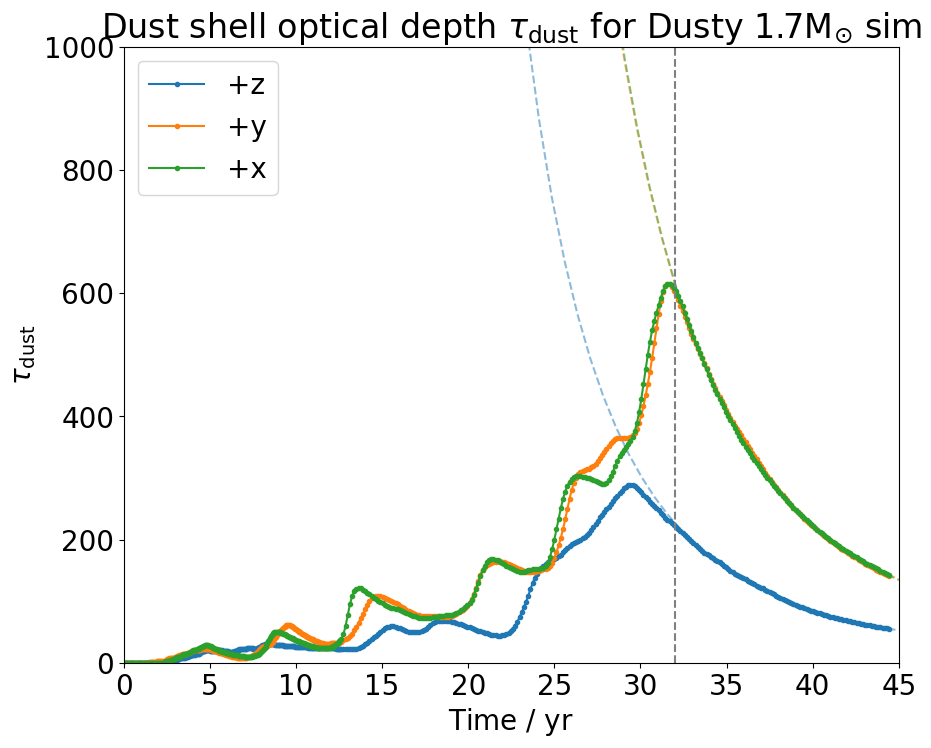

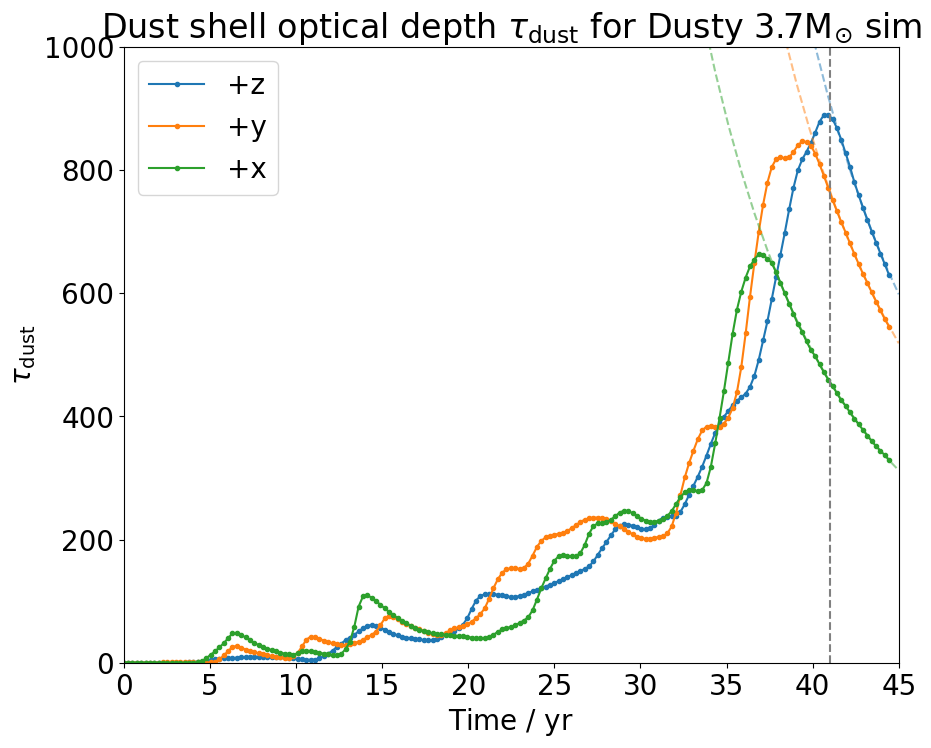

In [202]:
if __name__ == '__main__' and do_debug:

    xlim = (0, 45)

    t_dust_stop = {
        '2md': 32 * units.yr,
        '4md': 41 * units.yr,
    }

    # - set dust shell dispersion func -
    alpha0 = -10/3
    # f: get tau_dust from time
    f = lambda t, A, t0, alpha=alpha0: 10**A * (t - t0)**alpha
    # g: f^-1, i.e., get time from tau_dust
    g = lambda tau_dust, A, t0, alpha=alpha0: (tau_dust / 10**A)**(1/alpha) + t0
    

    for job_nickname in job_nicknames:
        job_profile = JOB_PROFILES_DICT[job_nickname]
        fig, ax = plt.subplots(figsize=(10, 8))

        # - read and plot original -
        with open(f"{interm_dir}taudust.{job_nickname}.json", 'r') as fp:
            data = mupl.json_load(fp, metadata)
        for ilabel, label in enumerate(['+z', '+y', '+x']):
            mask = np.isfinite(data['times'])
            xs = data['times'][mask]
            ys = data['v'][label]['tau_dust'][mask]
            ax.plot(xs, ys, '.-', label=f"{label}", color=f'C{ilabel}')
        
            # - prepare data -
            mk = xs > t_dust_stop[job_nickname]
            xs_d, ys_d = xs[mk].to_value(units.yr), ys[mk]
            # set initial guess p0
            t00 = 10.
            A0 = np.average(np.log10(ys_d / f(xs_d, 0., t00)))
            p0 = (A0, t00)
            # - fit and plot dispersion prediction -
            popt, pcov = curve_fit(f, xs_d, ys_d, p0=p0)
            perr = np.sqrt(np.diag(pcov))
            t0 = popt[1]
            xs_p = np.linspace(t0, xlim[1])
            ax.plot(xs_p, f(xs_p, *popt), '--', color=f'C{ilabel}', alpha=0.5)
            print(
                f"{job_nickname} {label}: {' \t'.join([f'$ {pv:.5f} \\pm {pe:.5f} $' for pv, pe in zip(popt, perr)])}",
                f"\n\tDust shell disperses at {g(PHOTOSPHERE_TAU, *popt):.3f} yr",
            )
    

        ax.axvline(t_dust_stop[job_nickname].to_value(units.yr), linestyle='--', color='grey')
        
        # - formatting -
        ax.set_xlim(xlim)
        # ax.set_ylim((0, 400))
        ax.set_xlabel(f"Time / {xs.unit.to_string('latex_inline')}")
        ax.set_ylabel(f"$\\tau_\\mathrm{{dust}}$")
        ax.legend(loc='upper left')
        ax.set_ylim((0, 1000))
        ax.set_title(f"{job_profile['name']}")
        fig.savefig(f"{output_dir}{job_nickname}_taudust.pdf")
        ax.set_title(f"Dust shell optical depth $\\tau_\\mathrm{{dust}}$ for {job_profile['name']} sim")
        fig.savefig(f"{output_dir}{job_nickname}_taudust.png")
    

In [201]:
help(curve_fit)

Help on function curve_fit in module scipy.optimize._minpack_py:

curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=None, bounds=(-inf, inf), method=None, jac=None, *, full_output=False, nan_policy=None, **kwargs)
    Use non-linear least squares to fit a function, f, to data.

    Assumes ``ydata = f(xdata, *params) + eps``.

    Parameters
    ----------
    f : callable
        The model function, f(x, ...). It must take the independent
        variable as the first argument and the parameters to fit as
        separate remaining arguments.
    xdata : array_like
        The independent variable where the data is measured.
        Should usually be an M-length sequence or an (k,M)-shaped array for
        functions with k predictors, and each element should be float
        convertible if it is an array like object.
    ydata : array_like
        The dependent data, a length M array - nominally ``f(xdata, ...)``.
    p0 : array_like, optional
       

In [162]:
if __name__ == '__main__' and do_debug:


    # - set func -
    alpha0 = -10/3
    # f: get tau_dust from time
    f = lambda t, A, t0, alpha=alpha0: 10**A * (t - t0)**alpha
    # g: f^-1, i.e., get time from tau_dust
    g = lambda tau_dust, A, t0, alpha=alpha0: (tau_dust / 10**A)**(1/alpha) + t0

    # - prepare data -
    xs = data['times']
    mk = xs > 42*units.yr # 33, 38
    ys = data['v']['+z']['tau_dust']
    xs, ys = xs[mk].to_value(units.yr), ys[mk]
    # initial guess p0
    t0 = 10.
    A0 = np.average(np.log10(ys / f(xs, 0., t0)))
    p0 = (A0, t0)

    # - fit -
    popt, pcov = curve_fit(f, xs, ys, p0=p0)
    perr = np.sqrt(np.diag(pcov))
    
xs, ys, A0, p0
popt, perr

(array([ 7.82691909, 12.20312222]), array([0.00811305, 0.17353497]))

Dust shell disperses at 263.915 yr


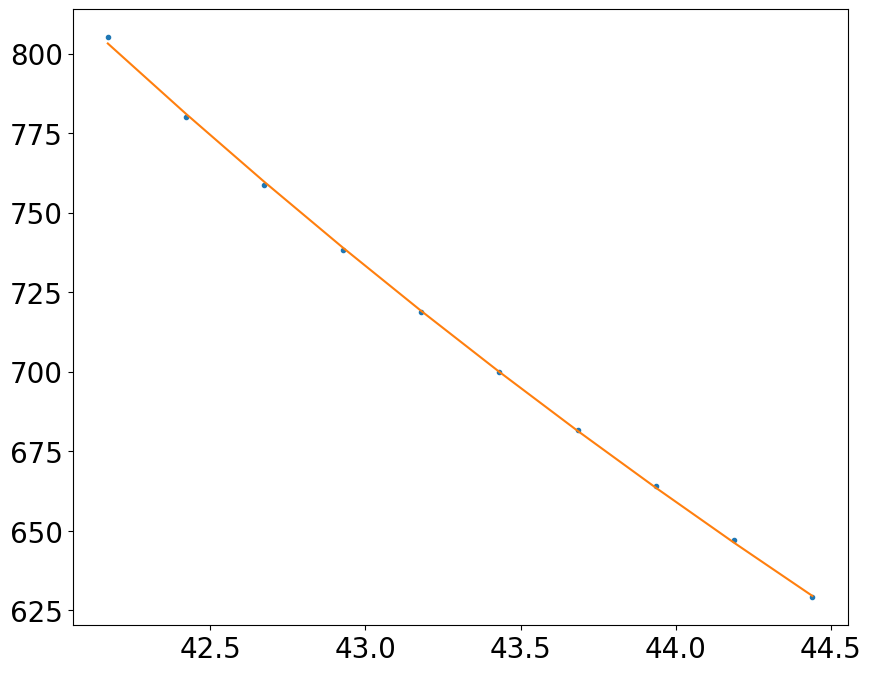

In [164]:
if __name__ == '__main__' and do_debug:
    # - plot -
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(xs, ys, '.')
    # ax.plot(xs, f(xs, *p0), '--')
    ax.plot(xs, f(xs, *popt))
    print(f"Dust shell disperses at {g(PHOTOSPHERE_TAU, *popt):.3f} yr")

In [35]:
help(curve_fit)

Help on function curve_fit in module scipy.optimize._minpack_py:

curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=None, bounds=(-inf, inf), method=None, jac=None, *, full_output=False, nan_policy=None, **kwargs)
    Use non-linear least squares to fit a function, f, to data.

    Assumes ``ydata = f(xdata, *params) + eps``.

    Parameters
    ----------
    f : callable
        The model function, f(x, ...). It must take the independent
        variable as the first argument and the parameters to fit as
        separate remaining arguments.
    xdata : array_like
        The independent variable where the data is measured.
        Should usually be an M-length sequence or an (k,M)-shaped array for
        functions with k predictors, and each element should be float
        convertible if it is an array like object.
    ydata : array_like
        The dependent data, a length M array - nominally ``f(xdata, ...)``.
    p0 : array_like, optional
       